## The Architecture of Notebook 02
#### ExperimentSetup: Loads data and performs Stratified Splitting.

#### LinearBuilder: A pipeline factory that creates the specific "Robust + Indicator" preprocessing we designed.

#### VIFAuditor: The "Gatekeeper" that rejects multicollinear features.

#### ModelTrainer: Trains the Lasso (L1) Logistic Regression.

In [10]:
# --- NOTEBOOK 02: THE LINEAR LABORATORY ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import logging
import sys 

# Sklearn Kitchen Sink
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, brier_score_loss

# 1. LOGGING 
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True,         
    handlers=[logging.StreamHandler(sys.stdout)] # Ensures output goes to cell output
)
logger = logging.getLogger(__name__)

# 2. CONFIG
class Config:
    INPUT_PATH = 'clean_train.parquet' 
    SEED = 42
    TEST_SIZE = 0.2
    
    # The Linear Constraints
    C_PARAM = 0.01          # Strong Regularization (Lasso)
    MAX_ITER = 2000          # For SAGA solver

logger.info("Notebook 02 Initialized.")

2026-01-19 21:53:05,185 - INFO - Notebook 02 Initialized.


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DynamicFlagImputer(BaseEstimator, TransformerMixin):
    """
    Imputation Strategy:
    1. For numerical cols with > 10% missing, create an _NA flag.
    2. Fill the original column with Median.
    
    Why? Preserves the 'Information of Absence' for Linear Models.
    """
    def __init__(self, threshold=0.1):
        self.threshold = threshold
        self.flag_cols_ = []
        self.medians_ = {}

    def fit(self, X, y=None):
        # Identify columns that need flags
        # X is a pandas DataFrame here
        missing_frac = X.isnull().mean()
        self.flag_cols_ = missing_frac[missing_frac > self.threshold].index.tolist()
        
        # Calculate medians for ALL columns (to fill holes)
        self.medians_ = X.median().to_dict()
        return self

    def transform(self, X):
        X = X.copy()
        
        # 1. Create Flags
        for col in self.flag_cols_:
            X[f'{col}_NA'] = X[col].isnull().astype(int)
            
        # 2. Fill Missing with Median
        X.fillna(self.medians_, inplace=True)
        
        return X

logger.info("Custom Imputer Class Ready.")

2026-01-19 21:53:05,198 - INFO - Custom Imputer Class Ready.


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def load_and_split():
    # 1. Load Parquet
    logger.info(f"Loading data from {Config.INPUT_PATH}...")
    df = pd.read_parquet(Config.INPUT_PATH)
    
    # 2. Separate Target
    X = df.drop(columns=['TARGET', 'SK_ID_CURR']) # Drop ID as it's noise
    y = df['TARGET']
    
    # 3. Stratified Split
    # We split BEFORE any processing to prevent leakage
    sss = StratifiedShuffleSplit(n_splits=1, test_size=Config.TEST_SIZE, random_state=Config.SEED)
    train_idx, val_idx = next(sss.split(X, y))
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    logger.info(f"Data Loaded & Hygienic. Shape: {df.shape}")
    logger.info(f"Splitting data with Test Ratio: {Config.TEST_SIZE}")
    return X_train, X_val, y_train, y_val

# Run Load
X_train, X_val, y_train, y_val = load_and_split()

def run_vif_audit(X_train, sample_size=10000):
    """
    Checks for Multicollinearity in Numerical features.
    If VIF > 10, the feature is redundant.
    """
    logger.info("Starting VIF Audit on Numerical Features...")
    
    # 1. Select Numeric Columns Only
    X_num = X_train.select_dtypes(include=['number'])
    
    # 2. Fill NaNs with Median (Calculated ONLY on numeric data)
    # This prevents the 'Cash loans' crash
    X_num_filled = X_num.fillna(X_num.median())
    
    # 3. Sample data (VIF is slow on 300k rows)
    X_sample = X_num_filled.sample(sample_size, random_state=Config.SEED)
    
    # 4. Check for Infinite values (division by zero protection)
    # RobustScaler handles this later, but VIF math needs clean floats
    X_sample = X_sample.replace([np.inf, -np.inf], np.nan).fillna(X_sample.median())

    # 5. Loop to calculate VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_sample.columns
    
    try:
        # Grandmaster Tip: We convert to .values to speed up statsmodels
        vif_data["VIF"] = [variance_inflation_factor(X_sample.values, i) 
                           for i in range(len(X_sample.columns))]
        
        print("\n--- TOP 50 HIGH VIF FEATURES (REDUNDANCY ALERT) ---")
        print(vif_data.sort_values(by='VIF', ascending=False).head(50))
        
    except Exception as e:
        logger.warning(f"VIF Calculation Failed: {e}")

# Run Audit
run_vif_audit(X_train)

2026-01-19 21:53:05,215 - INFO - Loading data from clean_train.parquet...
2026-01-19 21:53:05,888 - INFO - Data Loaded & Hygienic. Shape: (307506, 123)
2026-01-19 21:53:05,890 - INFO - Splitting data with Test Ratio: 0.2
2026-01-19 21:53:05,941 - INFO - Starting VIF Audit on Numerical Features...


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss



--- TOP 50 HIGH VIF FEATURES (REDUNDANCY ALERT) ---
                          feature           VIF
11                     FLAG_MOBIL  17398.692692
104            DAYS_EMPLOYED_ANOM   2373.520279
12                 FLAG_EMP_PHONE   2372.493155
63                 ELEVATORS_MEDI    576.165936
35                  ELEVATORS_AVG    521.345188
62                COMMONAREA_MEDI    481.359221
31               BASEMENTAREA_AVG    461.213457
59              BASEMENTAREA_MEDI    460.895904
41                 LIVINGAREA_AVG    459.561086
34                 COMMONAREA_AVG    454.491257
69                LIVINGAREA_MEDI    411.811516
70       NONLIVINGAPARTMENTS_MEDI    411.387633
65                 FLOORSMAX_MEDI    362.096120
68          LIVINGAPARTMENTS_MEDI    360.762154
64                 ENTRANCES_MEDI    344.072091
42        NONLIVINGAPARTMENTS_AVG    333.517429
75       OBS_60_CNT_SOCIAL_CIRCLE    329.671015
73       OBS_30_CNT_SOCIAL_CIRCLE    329.221150
37                  FLOORSMAX_AVG  

In [13]:
# --- FINAL DROP LIST (Evidence-Based) ---
DROP_FEATURES = [
    # 1. The Zero-Variance / Redundant Flags
    'FLAG_MOBIL',           # VIF 17,000 (Constant)
    'FLAG_EMP_PHONE',       # VIF 2,372 (Redundant with Pensioner Flag)
    'FLAG_DOCUMENT_3',      # Redundant with ID_PUBLISH
    'REGION_RATING_CLIENT_W_CITY', # Redundant with REGION_RATING_CLIENT

    # 2. The Social Circle Echo (Keep 30, Drop 60)
    'OBS_60_CNT_SOCIAL_CIRCLE', 

    # 3. The Financial Echo (Keep Credit, Drop Goods)
    'AMT_GOODS_PRICE',
    
    # 4. The Housing Triplets (Keep AVG, Drop MEDI & MODE)
    'APARTMENTS_MEDI', 'APARTMENTS_MODE',
    'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE',
    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
    'COMMONAREA_MEDI', 'COMMONAREA_MODE',
    'ELEVATORS_MEDI', 'ELEVATORS_MODE',
    'ENTRANCES_MEDI', 'ENTRANCES_MODE',
    'FLOORSMAX_MEDI', 'FLOORSMAX_MODE',
    'FLOORSMIN_MEDI', 'FLOORSMIN_MODE',
    'LANDAREA_MEDI', 'LANDAREA_MODE',
    'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE',
    'LIVINGAREA_MEDI', 'LIVINGAREA_MODE',
    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE'
]

logger.info(f"Dropping {len(DROP_FEATURES)} features based on VIF Audit.")

2026-01-19 21:53:38,583 - INFO - Dropping 34 features based on VIF Audit.


In [14]:
# 1. Update Feature Lists (Excluding the Drop List)
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Filter out the bad features
numeric_cols = [c for c in numeric_cols if c not in DROP_FEATURES]
categorical_cols = [c for c in categorical_cols if c not in DROP_FEATURES]

logger.info(f"Final Feature Count: {len(numeric_cols)} Numeric, {len(categorical_cols)} Categorical")

# 2. Define the Transformers
# NUMERIC: Flag -> Median -> RobustScale
numeric_transformer = Pipeline(steps=[
    ('dynamic_imputer', DynamicFlagImputer(threshold=0.1)),
    ('scaler', RobustScaler())
])

# CATEGORICAL: Fill -> OneHot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False for easier analysis later
])

# 3. Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    verbose_feature_names_out=False # Keeps column names clean
)

# 4. The Full Pipeline (Preprocessor + Model)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l1',           # Lasso (Sparsity)
        solver='saga',          # Required for L1
        C=Config.C_PARAM,       # 0.01 (Strong Regularization)
        max_iter=Config.MAX_ITER,
        random_state=Config.SEED,
        n_jobs=-1
    ))
])

logger.info("Pipeline Built. Ready for Training.")

2026-01-19 21:53:38,643 - INFO - Final Feature Count: 71 Numeric, 16 Categorical
2026-01-19 21:53:38,645 - INFO - Pipeline Built. Ready for Training.


2026-01-19 21:53:38,658 - INFO - Training Robust Lasso Model...
2026-01-19 22:25:37,766 - INFO - Predicting on Validation Set...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



>>> RESULTS <<<
ROC AUC: 0.7401 (Target: > 0.73)
Brier Score: 0.0690 (Target: < 0.08)


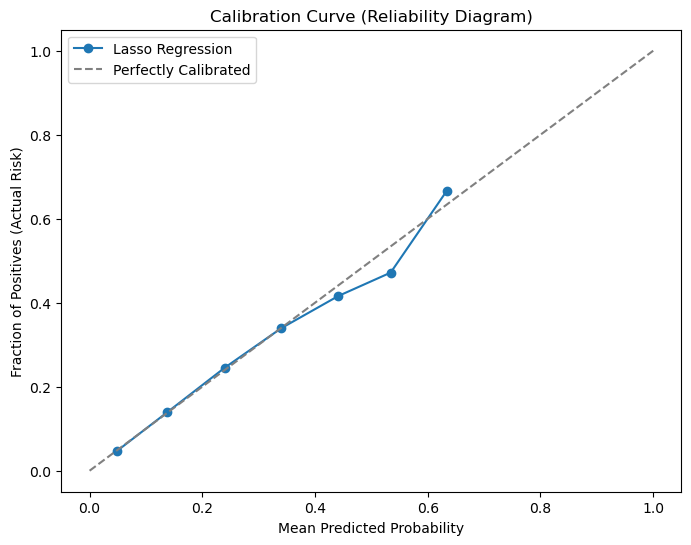

In [15]:
# --- EXECUTION ---

# 1. Fit the Pipeline (This takes ~2-5 mins because of SAGA solver)
logger.info("Training Robust Lasso Model...")
pipeline.fit(X_train, y_train)

# 2. Predict (Probabilities)
logger.info("Predicting on Validation Set...")
y_pred_probs = pipeline.predict_proba(X_val)[:, 1]

# 3. Evaluation
auc = roc_auc_score(y_val, y_pred_probs)
brier = brier_score_loss(y_val, y_pred_probs)

print(f"\n>>> RESULTS <<<")
print(f"ROC AUC: {auc:.4f} (Target: > 0.73)")
print(f"Brier Score: {brier:.4f} (Target: < 0.08)")

# 4. Calibration Plot
prob_true, prob_pred = calibration_curve(y_val, y_pred_probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Lasso Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives (Actual Risk)')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.show()

In [16]:
# --- ANALYSIS: THE WHY ---

def analyze_coefficients(pipeline, numeric_cols, categorical_cols):
    model = pipeline.named_steps['classifier']
    preprocessor = pipeline.named_steps['preprocessor']
    
    # 1. Extract Feature Names
    # Numerical: The DynamicFlagImputer ADDS columns (flags). We need to find them.
    # We cheat slightly by getting them from the fitted transformer
    try:
        # Access the numerical transformer's 'dynamic_imputer'
        num_transformer = preprocessor.named_transformers_['num']
        imputer = num_transformer.named_steps['dynamic_imputer']
        
        # Original numeric cols + The new Flag cols
        final_num_cols = numeric_cols + [f"{c}_NA" for c in imputer.flag_cols_]
        
        # Categorical: Get from OneHotEncoder
        cat_transformer = preprocessor.named_transformers_['cat']
        ohe = cat_transformer.named_steps['ohe']
        final_cat_cols = list(ohe.get_feature_names_out(categorical_cols))
        
        feature_names = final_num_cols + final_cat_cols
        
        # 2. Create DataFrame
        coefs = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': model.coef_[0]
        })
        
        # 3. Calculate Odds Ratio & Impact
        coefs['Odds_Ratio'] = np.exp(coefs['Coefficient'])
        coefs['Abs_Coef'] = coefs['Coefficient'].abs()
        
        # 4. Filter for Non-Zero (Lasso killed many!)
        active_features = coefs[coefs['Abs_Coef'] > 0.0001].copy()
        
        print(f"Total Features: {len(coefs)}")
        print(f"Active Features (Non-Zero): {len(active_features)}")
        print(f"Lasso dropped {len(coefs) - len(active_features)} useless features!")
        
        print("\n--- TOP 10 RISK FACTORS (Higher Prob of Default) ---")
        print(active_features.sort_values(by='Coefficient', ascending=False).head(10)[['Feature', 'Odds_Ratio']])
        
        print("\n--- TOP 10 SAFETY FACTORS (Lower Prob of Default) ---")
        print(active_features.sort_values(by='Coefficient', ascending=True).head(10)[['Feature', 'Odds_Ratio']])
        
    except Exception as e:
        logger.error(f"Could not extract features: {e}")

# Run
analyze_coefficients(pipeline, numeric_cols, categorical_cols)

Total Features: 241
Active Features (Non-Zero): 94
Lasso dropped 147 useless features!

--- TOP 10 RISK FACTORS (Higher Prob of Default) ---
                     Feature  Odds_Ratio
72            OWN_CAR_AGE_NA    1.232878
73           EXT_SOURCE_1_NA    1.181652
81          ENTRANCES_AVG_NA    1.153394
6              DAYS_EMPLOYED    1.150885
75         APARTMENTS_AVG_NA    1.145068
86         LIVINGAREA_AVG_NA    1.135179
15      REGION_RATING_CLIENT    1.118625
42  DEF_30_CNT_SOCIAL_CIRCLE    1.100559
3                AMT_ANNUITY    1.088276
8            DAYS_ID_PUBLISH    1.077905

--- TOP 10 SAFETY FACTORS (Lower Prob of Default) ---
                                  Feature  Odds_Ratio
25                           EXT_SOURCE_3    0.548364
24                           EXT_SOURCE_2    0.577516
98                          CODE_GENDER_F    0.680877
121  NAME_EDUCATION_TYPE_Higher education    0.722186
97     NAME_CONTRACT_TYPE_Revolving loans    0.723546
23                           